In [37]:
#import the neccessary libraries for analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.svm import SVC
import random
from sklearn import metrics 


In [38]:
#reading csv from the url
url = 'https://raw.githubusercontent.com/adebayoj/fairml/master/doc/example_notebooks/propublica_data_for_fairml.csv'
df = pd.read_csv(url, error_bad_lines=False,sep=',')
df.head()

,Two_yr_Recidivism,Number_of_Priors,score_factor,Age_Above_FourtyFive,Age_Below_TwentyFive,African_American,Asian,Hispanic,Native_American,Other,Female,Misdemeanor
0,0,0,0,1,0,0,0,0,0,1,0,0
1,1,0,0,0,0,1,0,0,0,0,0,0
2,1,4,0,0,1,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,0,1
4,1,14,1,0,0,0,0,0,0,0,0,0


In [39]:
#checking for missing data
df.isna().sum()

Two_yr_Recidivism       0
Number_of_Priors        0
score_factor            0
Age_Above_FourtyFive    0
Age_Below_TwentyFive    0
African_American        0
Asian                   0
Hispanic                0
Native_American         0
Other                   0
Female                  0
Misdemeanor             0
dtype: int64

From the above line of code we can see there are no missing data points in the data.

# Data Exploration

### Plotting the count of age distribution

{'Age_Above_FourtyFive': 1293, 'Age_Below_TwentyFive': 1347}


([<matplotlib.axis.XTick at 0x7f280a9db550>,
 [Text(0, 0, 'Age_Above_FourtyFive'), Text(1, 0, 'Age_Below_TwentyFive')])

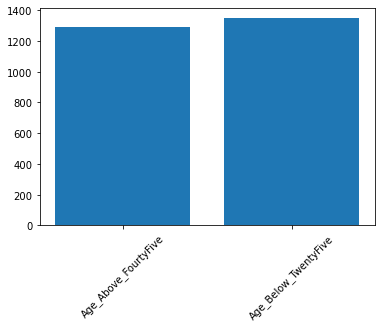

In [40]:
background=['Age_Above_FourtyFive','Age_Below_TwentyFive']
lst={}
for i in background:
    lst[i]=df[i].sum()
print(lst)
plt.bar(range(len(lst)), list(lst.values()), align='center')
plt.xticks(range(len(lst)), list(lst.keys()),rotation=45)

### Plotting the count of sex distribution

,% distribution,sex
0,80.962411,Male
1,19.037589,Female


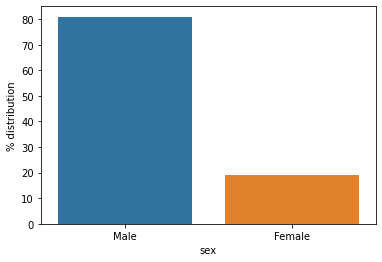

In [41]:
mf=pd.DataFrame(df.Female.value_counts()/len(df))*100
mf.rename(columns={'Female':"% distribution"},inplace=True)
mf['sex']=mf.index
mf['sex'] = np.where((mf['sex'] == 0), 'Male', 'Female')
sns.barplot(x="sex",y="% distribution",data =mf)
mf

#  2. Convicts who identify as white

In [42]:
#taking boolean sum of all other ethnicities to check if the individual elongs to another race
df['white_swap']=df.African_American.values+df.Asian.values+df.Hispanic.values+df.Native_American.values+df.Other.values
#reversing values of the sm values to get white-1/not-white-1
df['white'] = df.white_swap.map( lambda x: 0 if x == 1 else 1)
#dropping the original sum colum
df.drop(columns='white_swap',inplace=True)

In [43]:
df[df.white==1].head()

,Two_yr_Recidivism,Number_of_Priors,score_factor,Age_Above_FourtyFive,Age_Below_TwentyFive,African_American,Asian,Hispanic,Native_American,Other,Female,Misdemeanor,white
4,1,14,1,0,0,0,0,0,0,0,0,0,1
6,0,0,0,0,0,0,0,0,0,0,1,1,1
7,0,0,0,0,0,0,0,0,0,0,0,0,1
9,0,0,0,0,0,0,0,0,0,0,1,1,1
11,1,1,0,1,0,0,0,0,0,0,1,0,1


###  Plotting a distribution of count of the updated racial background

{'African_American': 3175, 'Asian': 31, 'Hispanic': 509, 'Native_American': 11, 'Other': 343, 'white': 2103}


([<matplotlib.axis.XTick at 0x7f28056ba580>,
 [Text(0, 0, 'African_American'),
  Text(1, 0, 'Asian'),
  Text(2, 0, 'Hispanic'),
  Text(3, 0, 'Native_American'),
  Text(4, 0, 'Other'),
  Text(5, 0, 'white')])

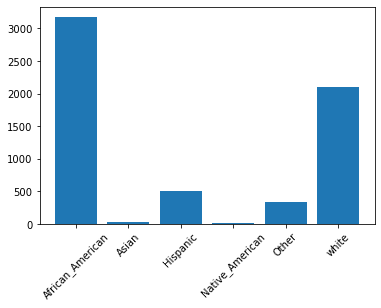

In [44]:
background=['African_American','Asian','Hispanic','Native_American','Other','white']
lst={}
for i in background:
    lst[i]=df[i].sum()
print(lst)
plt.bar(range(len(lst)), list(lst.values()), align='center')
plt.xticks(range(len(lst)), list(lst.keys()),rotation=45)


## 3.Add a column to the data set indicating the category of each convict. 

In [45]:
#a function to update columns based on the range of the numbr of priors
def f(c):
#return A if the number is 0
      if c['Number_of_Priors'] == 0:
        return 'A'
#return B if the number is between 1-3
      elif 0<c['Number_of_Priors']<=3:
        return 'B'
#return C if the number is between 4-10
      elif 3<c['Number_of_Priors']<=10:
        return 'C'
#return D otherwise
      else:
        return 'D'

In [46]:
# add a new column category and apply the above function to each of the rows
df['Category'] = df.apply(f, axis=1)

In [47]:
df[['Number_of_Priors','Category']]

,Number_of_Priors,Category
0,0,A
1,0,A
2,4,C
3,0,A
4,14,D
...,...,...
6167,0,A
6168,0,A
6169,0,A
6170,3,B


## 4.	Run regression models to determine the influence of the variables 

## on actual recidivism

In [48]:
#splitting data to exclude score_factor
mdata=df[['Number_of_Priors','Age_Below_TwentyFive','African_American','Hispanic','Native_American','Female','Misdemeanor','Two_yr_Recidivism']]
mdata.dtypes

Number_of_Priors        int64
Age_Below_TwentyFive    int64
African_American        int64
Hispanic                int64
Native_American         int64
Female                  int64
Misdemeanor             int64
Two_yr_Recidivism       int64
dtype: object

## on model predicted recidivism

In [49]:
#splitting data to exclude two_yr_recidivism
sdata=df[['Number_of_Priors','Age_Below_TwentyFive','African_American','Hispanic','Native_American','Female','Misdemeanor','score_factor']]
sdata.dtypes

Number_of_Priors        int64
Age_Below_TwentyFive    int64
African_American        int64
Hispanic                int64
Native_American         int64
Female                  int64
Misdemeanor             int64
score_factor            int64
dtype: object

### 4.1. Logistic Regression to predict two_yr_recidivim

/opt/conda/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


f1_score 0.6588399816022565
precision 0.6679312261326353
recall_score 0.6586925362817285
[[648 194]
 [317 384]]


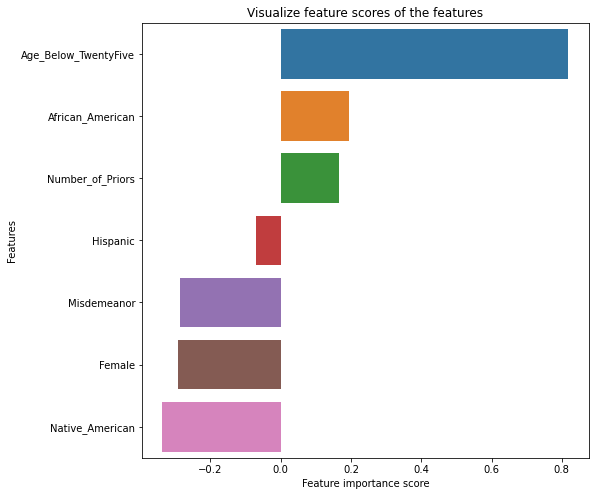

In [51]:
X=mdata[['Number_of_Priors','Age_Below_TwentyFive','African_American','Hispanic','Native_American','Female','Misdemeanor']]
y=mdata[['Two_yr_Recidivism']]
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25)
# Create an instance of the model. 
logreg = LogisticRegression() 
# Training the model. 
logreg.fit(X_train,y_train) 
# Do prediction. 
y_pred=logreg.predict(X_test)
print("f1_score",f1_score(y_test, y_pred, average="macro"))
print("precision",precision_score(y_test, y_pred, average="macro"))
print("recall_score",recall_score(y_test, y_pred, average="macro"))

#compute the feature scores
feature_scores = pd.Series(logreg.coef_[0], index=X_train.columns).sort_values(ascending=False)
feature_scores

# Analyzing the results by computing the confusion matrix
random.seed(1234)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print(cnf_matrix)


# Creating a seaborn bar plot of feature importance
f, ax = plt.subplots(figsize=(8,8))
ax = sns.barplot(x=feature_scores, y=feature_scores.index)
ax.set_title("Visualize feature scores of the features")
ax.set_yticklabels(feature_scores.index)
ax.set_xlabel("Feature importance score")
ax.set_ylabel("Features")
plt.show()

Results from the model:
Age has strong influence on prediction.
Race(African-American) and number of priors have almost the same importance. The features could be correlated or there is a bias present in the model

#  4.1.1  Feature  correlation plot

<AxesSubplot:>

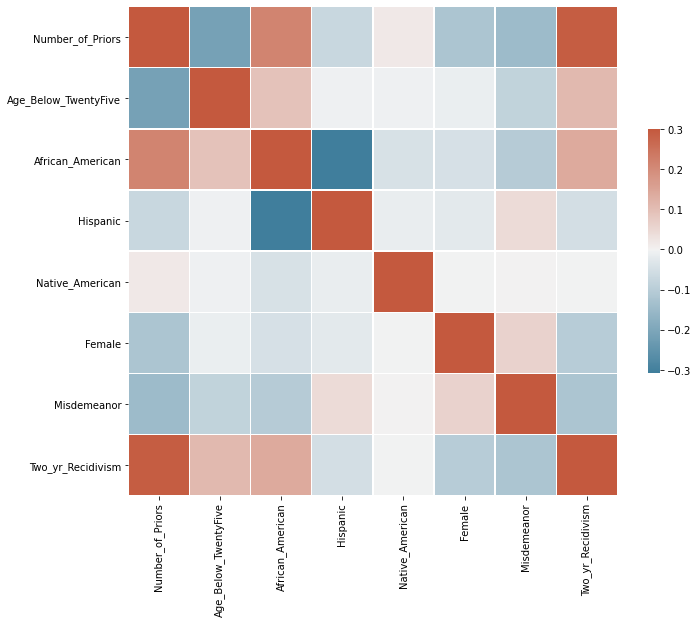

In [16]:
corr = mdata.corr()
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


Number of priors ,age below 25 and African amercican have strong positive correlation with two year recidivism,whereas female and misdemenour seem to have negative correlation

Number of priors and two years recidivism has high correlation with african american

The problem of co-linearity exists in our dataset -in the logistic regression model Age_Below_TwentyFive and African_American are closely linked, so it reduces the importance of the previous priors features, we can instead try non linear models such as decision tree

### 4.2. Non-Linear models to classify two year recidivism

In [17]:
X=mdata[['Number_of_Priors','Age_Below_TwentyFive','African_American','Hispanic','Native_American','Female','Misdemeanor']]
y=mdata[['Two_yr_Recidivism']]
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25)
clf = RandomForestClassifier(n_estimators=100, random_state=0)
xgb = XGBClassifier(n_estimators=100,use_label_encoder=False,base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1,  monotone_constraints='()',
               n_jobs=6, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', 
              validate_parameters=1, verbosity=None)
gnb = GaussianNB()
svc = SVC()
knn = KNeighborsClassifier()
lst={}

models=[clf,xgb,gnb,svc,knn]

for m in models:
# fit the model to the training set
    m.fit(X_train, y_train.values.ravel())
    # Do prediction. 
    y_pred=m.predict(X_test)
    print(m, "results:")
    print('Model accuracy score'. format(accuracy_score(y_test, y_pred)))
    print("f1_score",f1_score(y_test, y_pred, average="macro"))
    print("precision",precision_score(y_test, y_pred, average="macro"))
    print("recall_score",recall_score(y_test, y_pred, average="macro"))
    lst[m]=f1_score(y_test, y_pred, average="macro")

RandomForestClassifier(random_state=0) results:
Model accuracy score
f1_score 0.6339075716938312
precision 0.6416668145912843
recall_score 0.6347557248557177
[16:45:46] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=6, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate

([<matplotlib.axis.XTick at 0x7f2805809310>,
 [Text(0, 0, 'RandomForestClassifier(random_state=0)'),
  Text(1, 0, "XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,\n              importance_type='gain', interaction_constraints='',\n              learning_rate=0.300000012, max_delta_step=0, max_depth=6,\n              min_child_weight=1, missing=nan, monotone_constraints='()',\n              n_estimators=100, n_jobs=6, num_parallel_tree=1, random_state=0,\n              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,\n              tree_method='exact', use_label_encoder=False,\n              validate_parameters=1, verbosity=None)"),
  Text(2, 0, 'GaussianNB()'),
  Text(3, 0, 'SVC()'),
  Text(4, 0, 'KNeighborsClassifier()')])

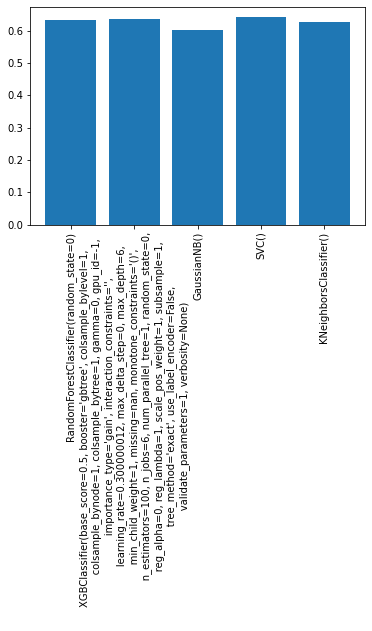

In [18]:
plt.bar(range(len(lst)), list(lst.values()), align='center')
plt.xticks(range(len(lst)), list(lst.keys()),rotation=90)

In [19]:
#getting the feature score from the model
feature_scores = pd.Series(clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_scores

Number_of_Priors        0.670484
Age_Below_TwentyFive    0.127998
African_American        0.065336
Female                  0.065322
Misdemeanor             0.045575
Hispanic                0.021291
Native_American         0.003994
dtype: float64

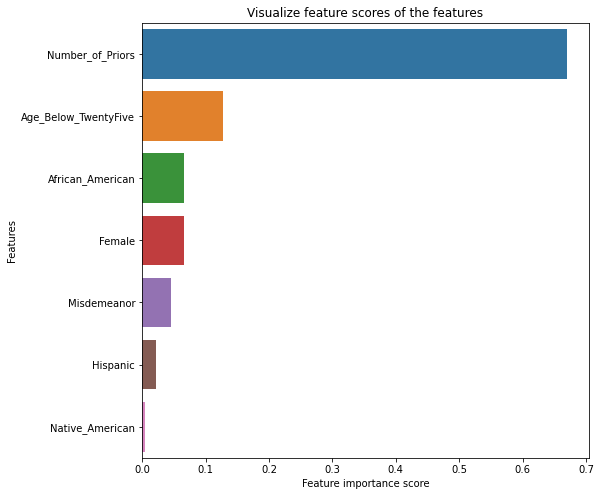

In [20]:
# Creating a seaborn bar plot
f, ax = plt.subplots(figsize=(8,8))
ax = sns.barplot(x=feature_scores, y=feature_scores.index)
ax.set_title("Visualize feature scores of the features")
ax.set_yticklabels(feature_scores.index)
ax.set_xlabel("Feature importance score")
ax.set_ylabel("Features")
plt.show()

## 4.3. Logistic regression to predict score_factor

/opt/conda/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


f1_score 0.7323341514103283
precision 0.7400420661729223
recall_score 0.7315782815504503


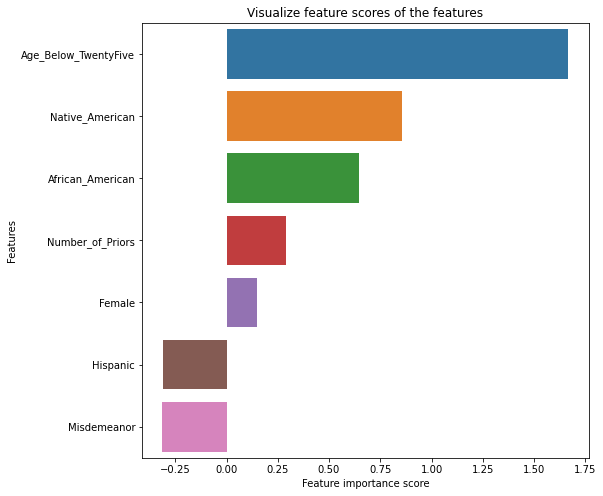

In [21]:
X=sdata[['Number_of_Priors','Age_Below_TwentyFive','African_American','Hispanic','Native_American','Female','Misdemeanor']]
y=sdata[['score_factor']]
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25)
# Create an instance of the model. 
logreg = LogisticRegression() 
# Training the model. 
logreg.fit(X_train,y_train) 
# Do prediction. 
y_pred=logreg.predict(X_test)
print("f1_score",f1_score(y_test, y_pred, average="macro"))
print("precision",precision_score(y_test, y_pred, average="macro"))
print("recall_score",recall_score(y_test, y_pred, average="macro"))


feature_scores = pd.Series(logreg.coef_[0], index=X_train.columns).sort_values(ascending=False)
feature_scores
# Creating a seaborn bar plot

f, ax = plt.subplots(figsize=(8,8))
ax = sns.barplot(x=feature_scores, y=feature_scores.index)
ax.set_title("Visualize feature scores of the features")
ax.set_yticklabels(feature_scores.index)
ax.set_xlabel("Feature importance score")
ax.set_ylabel("Features")
plt.show()

## 4.4. Non-linear models to predict score_factor

## 

In [22]:
X=sdata[['Number_of_Priors','Age_Below_TwentyFive','African_American','Hispanic','Native_American','Female','Misdemeanor']]
y=sdata[['score_factor']]
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25)
clf = RandomForestClassifier(n_estimators=100, random_state=0)
xgb = XGBClassifier(n_estimators=100,use_label_encoder=False,base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1,  monotone_constraints='()',
               n_jobs=6, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', 
              validate_parameters=1, verbosity=None)
gnb = GaussianNB()
svc = SVC()
knn = KNeighborsClassifier()
lst={}

models=[clf,xgb,gnb,svc,knn]

for m in models:
# fit the model to the training set
    m.fit(X_train, y_train.values.ravel())
    # Do prediction. 
    y_pred=m.predict(X_test)
    print(m, "results:")
    print('Model accuracy score with 100 decision-trees : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))
    print("f1_score",f1_score(y_test, y_pred, average="macro"))
    print("precision",precision_score(y_test, y_pred, average="macro"))
    print("recall_score",recall_score(y_test, y_pred, average="macro"))
    lst[m]=precision_score(y_test, y_pred, average="macro")


RandomForestClassifier(random_state=0) results:
Model accuracy score with 100 decision-trees : 0.7472
f1_score 0.7393228814704689
precision 0.7442871240021851
recall_score 0.7370943687938896
[16:45:49] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=6, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_enco

In [23]:
feature_scores = pd.Series(clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_scores

Number_of_Priors        0.569390
Age_Below_TwentyFive    0.180937
African_American        0.143086
Misdemeanor             0.056995
Female                  0.024841
Hispanic                0.020554
Native_American         0.004197
dtype: float64

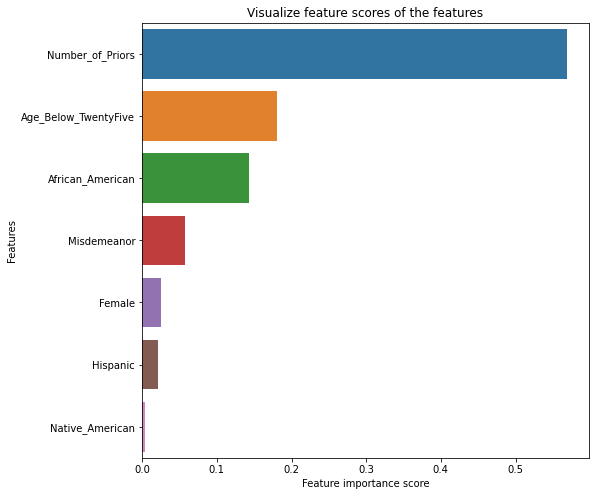

In [24]:
# Creating a seaborn bar plot
f, ax = plt.subplots(figsize=(8,8))
ax = sns.barplot(x=feature_scores, y=feature_scores.index)
ax.set_title("Visualize feature scores of the features")
ax.set_yticklabels(feature_scores.index)
ax.set_xlabel("Feature importance score")
ax.set_ylabel("Features")
plt.show()

## CHI- Square Test for feature importance

In [25]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

X=mdata[['Number_of_Priors','Age_Below_TwentyFive','African_American','Hispanic','Native_American','Female','Misdemeanor']]
y=mdata[['Two_yr_Recidivism']]
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=7)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(7,'Score'))  #print 10 best features

                  Specs        Score
0      Number_of_Priors  3612.507831
1  Age_Below_TwentyFive    59.478137
2      African_American    59.253526
6           Misdemeanor    57.485187
5                Female    50.884624
3              Hispanic    14.415053
4       Native_American     0.000015


# 6. Identifying biases in model results

# Analysis for population where model identifies false positives

## Analysis of racial background

{'African_American': 641, 'Asian': 2, 'Hispanic': 62, 'Native_American': 3, 'Other': 28, 'white': 282}


([<matplotlib.axis.XTick at 0x7f2800dcc6d0>,
 [Text(0, 0, 'African_American'),
  Text(1, 0, 'Asian'),
  Text(2, 0, 'Hispanic'),
  Text(3, 0, 'Native_American'),
  Text(4, 0, 'Other'),
  Text(5, 0, 'white')])

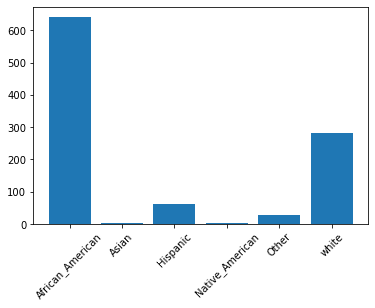

In [26]:
#extrating rows where score_factor dont match Two_yr_Recidivism
df1=df[df['score_factor']!=df['Two_yr_Recidivism']]

#extrating rows where the model inaccurately predicts a person guilty
g=df1[df1.score_factor==1]
#analysing the backgroung information
background=['African_American','Asian','Hispanic','Native_American','Other','white']
lst={}
for i in background:
    lst[i]=g[i].sum()
print(lst)
plt.bar(range(len(lst)), list(lst.values()), align='center')
plt.xticks(range(len(lst)), list(lst.keys()),rotation=45)

In [27]:
#constructing a dataframe from the dictionary obtained above
orient=pd.DataFrame.from_dict(lst, orient='index', dtype=None, columns=['count'])
orient['ethnicities']=orient.index
orient['% ethnicity']=(orient['count']/orient['count'].sum())*100
orient.reset_index(drop=True, inplace=True)
orient.sort_values(by=['% ethnicity'], ascending=False)[['ethnicities','% ethnicity']]

,ethnicities,% ethnicity
0,African_American,62.966601
5,white,27.701375
2,Hispanic,6.090373
4,Other,2.750491
3,Native_American,0.294695
1,Asian,0.196464


## Analysis of age

In [28]:
ageg=g[['Age_Above_FourtyFive','Age_Below_TwentyFive']]
print("Age_Above_FourtyFive:",np.round(ageg.Age_Above_FourtyFive.sum()/(ageg.Age_Above_FourtyFive.sum()+ageg.Age_Below_TwentyFive.sum())*100,2),"%")
print("Age_Below_TwentyFive:",np.round(ageg.Age_Below_TwentyFive.sum()/(ageg.Age_Above_FourtyFive.sum()+ageg.Age_Below_TwentyFive.sum())*100,2),"%")

Age_Above_FourtyFive: 26.62 %
Age_Below_TwentyFive: 73.38 %


<AxesSubplot:xlabel='ethnicities', ylabel='% ethnicity'>

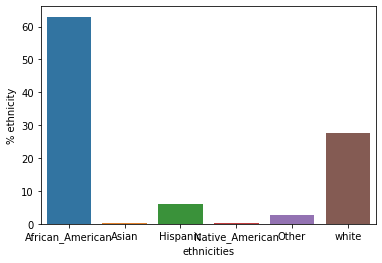

In [29]:
sns.barplot(x=orient['ethnicities'], y=orient['% ethnicity'])

# Analysis for population where model identifies false negatives

In [30]:
#extrating rows where the model inaccurately predicts a person non-guilty

ng=df1[df1.score_factor==0]

background=['African_American','Asian','Hispanic','Native_American','Other','white']
lst1={}
for i in background:
    lst1[i]=ng[i].sum()
print(lst1)


{'African_American': 473, 'Asian': 3, 'Hispanic': 110, 'Native_American': 0, 'Other': 82, 'white': 408}


## Analysis of racial background

In [31]:
#constructing a dataframe from the dictionary obtained above

norient=pd.DataFrame.from_dict(lst1, orient='index', dtype=None, columns=['count'])
norient['ethnicities']=norient.index
norient['% ethnicity']=(norient['count']/norient['count'].sum())*100
norient.reset_index(drop=True, inplace=True)
norient.sort_values(by=['% ethnicity'], ascending=False)

,count,ethnicities,% ethnicity
0,473,African_American,43.959108
5,408,white,37.918216
2,110,Hispanic,10.223048
4,82,Other,7.620818
1,3,Asian,0.278810
3,0,Native_American,0.000000


<AxesSubplot:xlabel='ethnicities', ylabel='% ethnicity'>

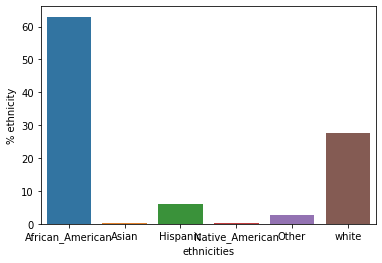

In [32]:
sns.barplot(x=norient['ethnicities'], y=orient['% ethnicity'])

## Analysis of age


In [33]:
ageng=ng[['Age_Above_FourtyFive','Age_Below_TwentyFive']]
print("Age_Above_FourtyFive:",np.round(ageng.Age_Above_FourtyFive.sum()/(ageng.Age_Above_FourtyFive.sum()+ageng.Age_Below_TwentyFive.sum())*100,2),"%")
print("Age_Below_TwentyFive:",np.round(ageng.Age_Below_TwentyFive.sum()/(ageng.Age_Above_FourtyFive.sum()+ageng.Age_Below_TwentyFive.sum())*100,2),"%")

Age_Above_FourtyFive: 54.34 %
Age_Below_TwentyFive: 45.66 %


### Correlation plot on the entire dataframe

<AxesSubplot:>

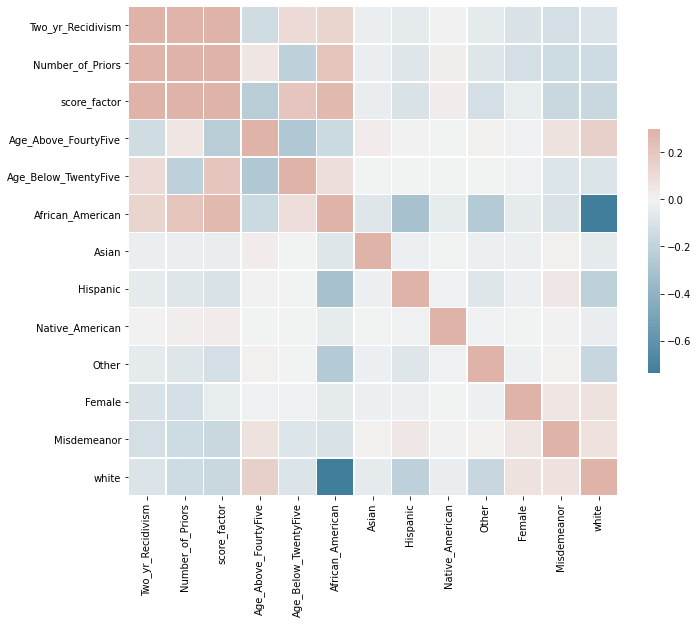

In [34]:
corr = df.corr()
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Analysis of gender

In [35]:
ng.Female.value_counts()

0    909
1    167
Name: Female, dtype: int64

In [36]:
g.Female.value_counts()

0    788
1    230
Name: Female, dtype: int64